# Analyzing patterns of benthic communities/species 

This notebook goes over a few examples of analyses which are typically done to discern patterns of benthic species. They include: multivariate analyses (community similarity and environmental drivers), and responses of individual species to environmental factors. All data are from the MAREANO Programme.

## Load the species and station data, if saved locally

In [9]:
samples <-  read.csv("tab_station.csv",header=T)
data   <- read.csv("tab_videolog_files.csv",header=T)

## Load the data (stations) from the MarBunn Database

In [1]:
# database connection details: marbunn@postgres9.imr.no:5432 pw: xxxxxxx

# run sql: select 
#          refstation_no,sample_no,latitude,longitude,location from tab_station where equipment=2 order by datetime;

# save as: "tab_station.csv"

Writing sql.txt


## Edit the station table for later use

In [11]:
samples$LAT <- as.numeric(as.character(substr(samples$latitude,1,2)) ) + 
  as.numeric(as.character(substr(samples$latitude,3,9999)) )/60

samples$LONG <- samples$longitude

for(i in 1:dim(samples)[1]){
  
  if(samples$longitude[i] > 999){
    samples$LONG[i] <- as.numeric(as.character(substr(samples$longitude[i],1,2)) ) + 
      as.numeric(as.character(substr(samples$longitude[i],3,9999)) )/60
  }
  else {
    samples$LONG[i] <- as.numeric(as.character(substr(samples$longitude[i],1,1)) ) + 
      as.numeric(as.character(substr(samples$longitude[i],2,9999)) )/60
  }
}

## Load the species data for each station, from the MarBunn Database

In [ ]:
#  run sql: SELECT tvl.*, rkw.known_wrong, rkw.id_videospecies, rvs.id, rvs.valid_species_name
#           FROM tab_video_logfiles tvl
#           LEFT JOIN ref_known_wrong_videospecies rkw ON tvl.biology_observation ilike rkw.known_wrong
#           LEFT JOIN ref_videospecies rvs ON tvl.biology_observation ilike rvs.valid_species_name OR rkw.id_videospecies = rvs.id
#           WHERE tvl.biology_observation  is not null AND tvl.originator = 'Biology'
#           ORDER BY sample_no, date_time; 

#  save as: "tab_video_logfiles.csv"

## Aggregating the data in different ways

### Output 1: species richness per station

In [6]:
output <- aggregate(!is.na(data$id),by=list(data$sample_no), sum)

colnames(output)<-c("sample_no", "count_valid_taxa")

output <- merge(output,samples, all.y=TRUE)

write.csv(output, "output1.csv", row.names=F)

### Output 2: total number of coral species by station

In [8]:
coral_spp <- c("Alcyonacea", "Isidella lofotensis", "Paragorgia arborea", "Paramuricea placomus",
             "Primnoa resedaeformis", "Radicipes sp.")

subdata <- data[data$valid_species_name %in% coral_spp,]

output <- aggregate(!is.na(subdata$id),by=list(subdata$sample_no), sum)

colnames(output)<-c("sample_no", "count_Hcorals")

output <- merge(output,samples, all.y=TRUE)

write.csv(output[!is.na(output$count_Hcorals),], "output2.csv", row.names=F)

### Output 3: presence/absence of one particular species (e.g. L. pertusa)

In [7]:
one_spp <- c("Parastichopus tremulus")

subdata <- data[data$valid_species_name == one_spp,]

output <- aggregate(!is.na(subdata$id),by=list(subdata$sample_no), sum)

colnames(output)<-c("sample_no", "count_SppX")

output <- merge(output,samples, all.y=TRUE)

write.csv(output, "output4.csv", row.names=F)

## Multivariate patterns

### Getting the data in the right format etc

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-5


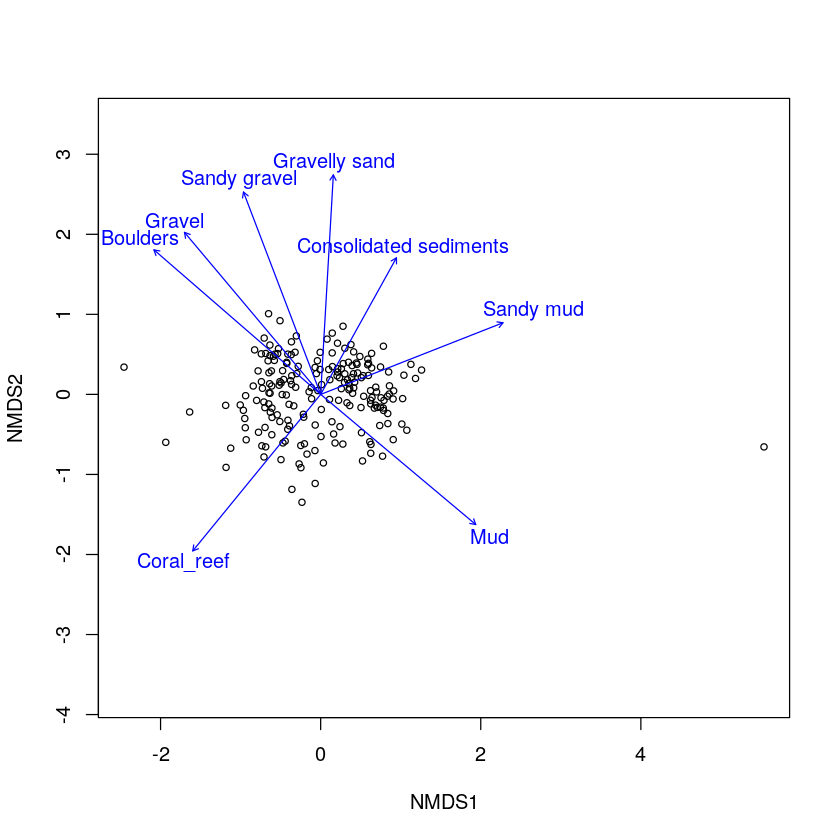

In [4]:
library(vegan)

data.sel <- data[data$ship_lon_deg>12 & data$ship_lon_deg<16,]

sppdata <- data.sel[data.sel$valid_species_name!="",colnames(data.sel)==c("sample_no","valid_species_name")]
sppdata$Value <- 1

sppmatrix<-xtabs(sppdata$Value~sppdata$sample_no+sppdata$valid_species_name)
sppmatrix<-as.data.frame.matrix(sppmatrix)

#dca <- decorana(sppmatrix)

sedidata <- data.sel[data.sel$bottom_observation!="No observation",colnames(data.sel)%in%c("sample_no","bottom_observation")]
sedidata$Value <- 1

sedidata$bottom_observation <-gsub("Coral reef", "Coral_reef", sedidata$bottom_observation)

sedimatrix<-xtabs(sedidata$Value~sedidata$sample_no+sedidata$bottom_observation) 
sedimatrix<-as.data.frame.matrix(sedimatrix)

nmds <- metaMDS(sppmatrix, trace = FALSE)

ef <- envfit(nmds, sedimatrix, permu = 99)

plot(nmds, display = "sites")
plot(ef, p.max = 0.1)

### Surface fitting


Family: gaussian 
Link function: identity 

Formula:
y ~ s(x1, x2, k = 10, bs = "tp", fx = FALSE)

Estimated degrees of freedom:
5.15  total = 6.15 

REML score: 949.9623     

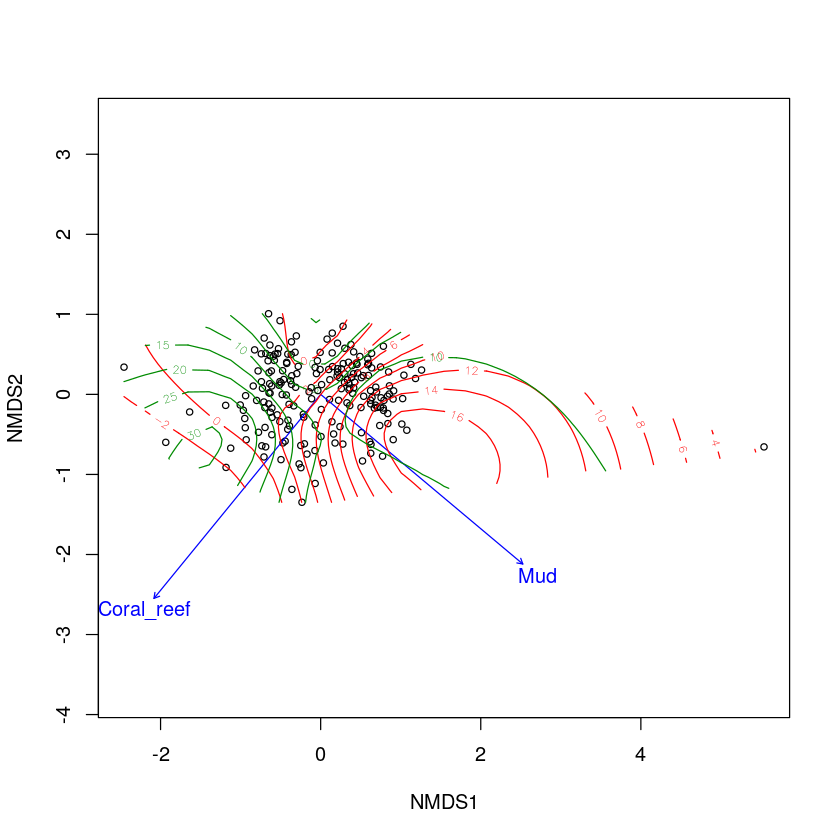

In [5]:
ef <- envfit(nmds ~ Coral_reef + Mud, sedimatrix)
plot(nmds, display = "sites")
plot(ef)
tmp <- with(sedimatrix, ordisurf(nmds, Mud, add = TRUE))
with(sedimatrix, ordisurf(nmds, Coral_reef + Mud, add = TRUE, col = "green4"))

## Get additional environmental data from raster

In [12]:
library(raster)

minT <- raster("NorKyst800_Troms_stat_2010_minT.tif")

# convert samples to spatial data

coordinates(samples)<-~LONG+LAT
proj4string(samples) <- CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
samples <- spTransform(samples,
                        CRS=CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"))

v<-extract(minT, samples)
v<-cbind(v,samples@data$sample_no)
colnames(v)<- c("minT","sample_no")
v1<-merge(v,output)


Warning message:
In grep("Band_", mdata): input string 15 is invalid in this localeWarning message:
In .local(x, y, ...): Transforming SpatialPoints to the CRS of the Raster

In [13]:
head(v1)

,sample_no,minT,count_SppX,refstation_no,latitude,longitude,location,LONG,LAT
1,1,-0.66635,NA,9001,6951.96,1532.38,,15.5396666666667,69.866
2,2,4.7875,NA,2,7121.02133,2223.8745,FINNMARK VEST - Tromsøflaket,22.3979083333333,71.3503555
3,3,4.7922,NA,3,7119.65133,2225.41583,FINNMARK VEST - Tromsøflaket,22.4235971666667,71.3275221666667
4,4,4.7629,NA,4,7119.43333,2228.96667,FINNMARK VEST - Tromsøflaket,22.4827778333333,71.3238888333333
5,5,4.76,NA,5,7117.48333,2232.41717,FINNMARK VEST - Tromsøflaket,22.5402861666667,71.2913888333333
6,6,4.8027,NA,6,7116.30491,2219.3185,FINNMARK VEST - Tromsøflaket,22.321975,71.2717485


### How was this geoTiff actually generated?

ERROR: Error in !ls: invalid argument type


## Modeling species-environment relationships

Generalized least squares fit by REML
  Model: count_SppX ~ minT 
  Data: v2 
  Log-restricted-likelihood: -1253.803

Coefficients:
(Intercept)        minT 
   3.126486    0.256755 

Degrees of freedom: 423 total; 421 residual
Residual standard error: 4.687427 

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
model0.ml,"gls(model = count_SppX ~ 1, data = v2, method = ""ML"")",1,2,2510.62726872975,2518.72201308784,-1253.31363436487,,NA,NA
model1.ml,"gls(model = count_SppX ~ minT, data = v2, method = ""ML"")",2,3,2511.38894332283,2523.53105985997,-1252.69447166141,1 vs 2,1.23832540691819,0.265794032973814


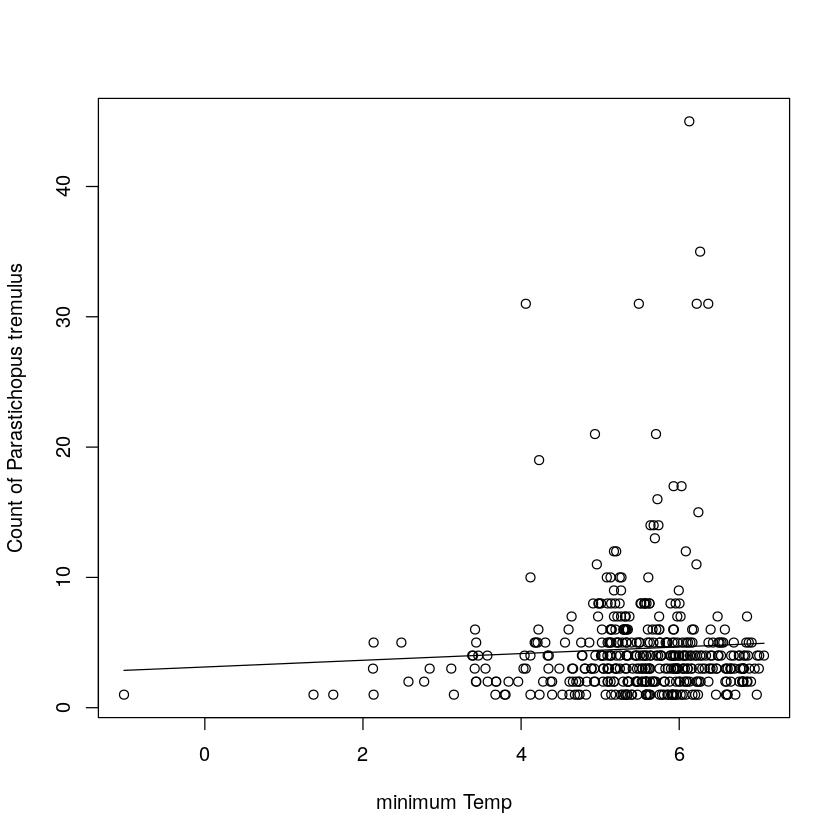

In [16]:
# using least squares regression

library(nlme)

v1<-v1[,1:3]
v2<-v1[complete.cases(v1),]

model1<- gls(count_SppX~minT, v2)
model1

# test the significance of the term (first fit null model)

model0<-gls(count_SppX~1, v2)

model0.ml <- update(model0, . ~ ., method = "ML")
model1.ml <- update(model1, . ~ ., method = "ML")
anova(model0.ml, model1.ml)


# Make a plot -------------------------------------------------------------

plot(v2$count_SppX~v2$minT,
     main="", 
     xlab="minimum Temp",
     ylab="Count of Parastichopus tremulus")
lines(sort(fitted(model1))~sort(v2$minT))

In [19]:
# using gam

library(gam)

gam1 <- gam(count_SppX>0~s(minT),family=binomial)

Installing package into ‘/usr/lib/R/library’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("gam"): 'lib = "/usr/lib/R/library"' is not writable

ERROR: Error in install.packages("gam"): unable to install packages
